In [1]:
import thirdparty
from thirdparty import *
from transformers import BlipProcessor, BlipForQuestionAnswering

# 导入模型

In [28]:
device=get_device()
model_dir="/root/autodl-tmp/model/"#/root/autodl-tmp/model/
model_path = os.path.join(model_dir,"blip-vqa-base")
processor = BlipProcessor.from_pretrained(model_path)
model = BlipForQuestionAnswering.from_pretrained(model_path).to(device)
print(model)

/root/miniconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

# 导入数据

In [29]:
text_dir = "/root/autodl-tmp/data/image-text-match/"
with open(os.path.join(text_dir,"train_data"),encoding="utf-8") as f:
    train_lines=[eval(s.strip()) for s in f.readlines()]
print(train_lines[0])
print (len(train_lines))
with open(os.path.join(text_dir,"val_data"),encoding="utf-8") as f:
    val_lines=[eval(s.strip()) for s in f.readlines()]
print(val_lines[0])
print (len(val_lines))
def get_data(lines,path_dir,num=200):
    lines=[s for s in lines  if len(s[1])>0 and len(s[1])<20]
    images=[]
    texts=[]
    for p,text in lines:
        try:  
            path=str(path_dir)+p   
            images.append(path)        
            texts.append(text)
        except:
            continue
    return images,texts
images_dir,texts=get_data(train_lines,"/root/autodl-tmp/data/COCO/train_image/")

['000000203564.jpg', '自行车复制品 时钟当前轮']
591753
['000000179765.jpg', '一辆黑色本田摩托车停在车库前']
25014


# 模型测试

In [30]:
def get_raw_image(index):
    image_path,text = images_dir[index],texts[index]
    raw_image = Image.open(image_path).convert('RGB')
    return raw_image

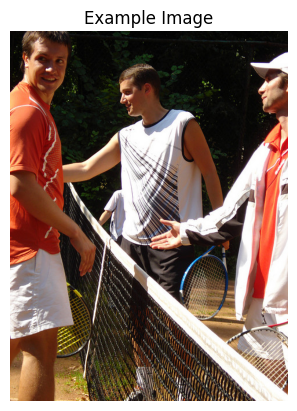

In [31]:
index = 135400
raw_image = get_raw_image(index)
image_show(np.array(raw_image),"rgb")

In [32]:
question="Are they playing soccer?"
inputs = processor(images=raw_image, text=question, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

no


/root/miniconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


# 导入训练数据

In [7]:
def get_data(path):
    with open(path,encoding="utf-8") as f:
        lines=[ eval(s.strip()) for s in f.readlines()]    
    random.shuffle(lines)
    questions= []
    images = []
    answers = []
    for question,answer,img_path in lines:
        img_path = img_path.replace("E:\\code\\clip\\train_image\\", "/root/autodl-tmp/data/COCO/train_image/")  
        questions.append(question)        
        answers.append(answer)
        images.append(img_path)    
    return images,questions,answers
train_images_dir,train_questions,train_answers=get_data("/root/autodl-tmp/data/image-text-question/train_data")

In [8]:
print(len(train_images_dir),len(train_answers))

82783 82783


In [9]:
class ToIntTensor(object):
    def __call__(self, pic):
        tensor = transforms.functional.to_tensor(pic)
        tensor = (tensor * 255).to(torch.uint8)
        return tensor
show_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    ToIntTensor()
])
class ImageTextDataset(Dataset):
    def __init__(self, image_paths, questions,answers,transform=None):
        self.image_paths = image_paths
        self.questions = questions
        self.answers = answers
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        # 加载图像
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        # 加载文本
        question = self.questions[idx]
        answer = self.answers[idx]
        if self.transform:
            image = self.transform(image)
        return image, question,answer

In [10]:
batch_size = 256
train_dataset=ImageTextDataset(train_images_dir,train_questions,train_answers,transform=show_tfm)
train_set = DataLoader(train_dataset, batch_size=batch_size,shuffle = True)

# 训练

In [21]:
config = {
    'n_epochs': 2,                # maximum number of epochs              
    'optimizer': 'Adam',             # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0003,                 # learning rate of Adam
        'betas' : (0.9,0.999),           #hyperparameter for momentum and gradient
        'eps':1e-5,                  # parameter for zero division
        'weight_decay': 1e-8        # weight decay (L2 regularization)  
    },
    'batch_show_step':10,
    'epoch_show_step':1,
    'save_dir':'./finetune-model/blip/',
}
myseed = 42069  # set a random seed for reproducibility
set_seed(myseed)

In [56]:
def train(train_set, model, config, device):
    ''' Model training '''
    n_epochs = config['n_epochs']  # Maximum number of epochs
    batch_show_step,epoch_show_step=config["batch_show_step"],config["epoch_show_step"]
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])
    min_loss = 10000.
    epoch = 0
    while epoch < n_epochs:
        model.train()
        step = 0
        show_flag=False
        if((epoch + 1) % epoch_show_step == 1 or epoch_show_step == 1): show_flag=True
        for images, questions,answers in train_set:  # iterate through the dataloader
            optimizer.zero_grad() # 梯度置零，因为反向传播过程中梯度会累加上一次循环的梯度
            inputs = processor(images=images, text=questions, return_tensors="pt",padding=True,truncation=True,max_length=30)
            #答案编码
            labels = processor(text=answers, return_tensors="pt",padding=True,truncation=True,max_length=10).input_ids
            inputs["labels"] = labels
            inputs=inputs.to(device) 
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward() # loss反向传播
            optimizer.step() # 反向传播后参数更新
            step += 1
            if(show_flag):
                if (step % batch_show_step == 1 or batch_show_step==1):
                    print('epoch{:4d}|step = {:4d}, train_loss = {:.4f}'.format(epoch + 1, step,loss))
            if(step%5==0):
                model.save_pretrained(config['save_dir'])
                torch.save(model, os.path.join(config['save_dir'],"pytorch_model.bin"))

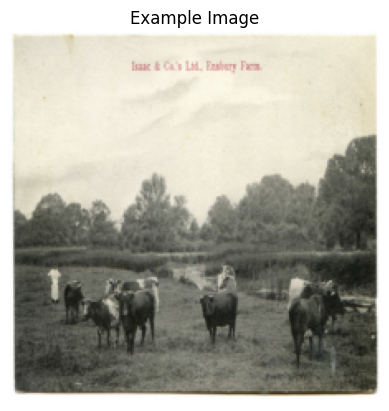

What kind of animals are pictured?
cows
epoch   1|step =    1, train_loss = 2.2749


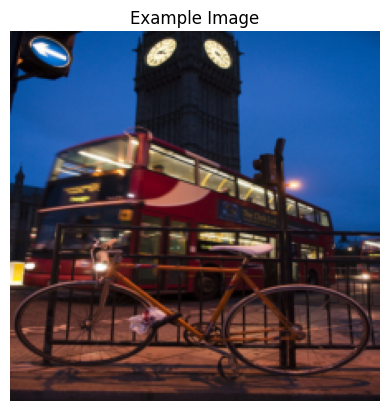

What color is the bicycle?
orange


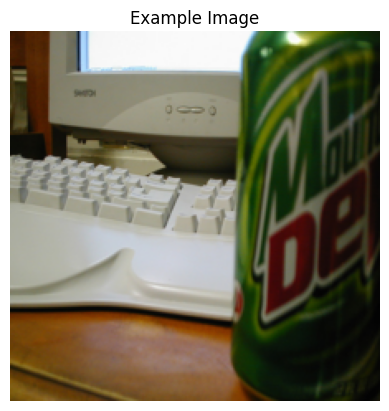

What kind of soda is on the desk?
mountain dew


KeyboardInterrupt: 

In [57]:
for name, param in model.vision_model.named_parameters():
    param.requires_grad=False
train(train_set,model,config,device)

# 模型比较

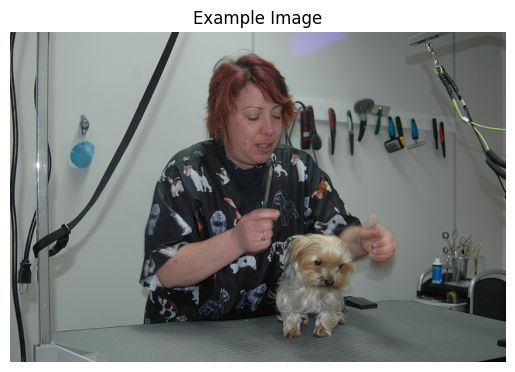

no



In [55]:
def get_raw_image_train(index):
    image_path = train_images_dir[index]
    raw_image = Image.open(image_path).convert('RGB')
    return raw_image
index = 3400
raw_image = get_raw_image_train(index)
image_show(np.array(raw_image),"rgb")
question="Is there a man?"
inputs = processor(images=raw_image, text=question, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs)
model_dir="/root/autodl-tmp/model/"#/root/autodl-tmp/model/
model_path = os.path.join(model_dir,"blip-vqa-base")
self_path = "./finetune-model/blip"
processor = BlipProcessor.from_pretrained(model_path)
model_blip = BlipForQuestionAnswering.from_pretrained(model_path).to(device)
model_self = BlipForQuestionAnswering.from_pretrained(self_path).to(device)
outputs = model_blip.generate(**inputs)
outputs_self = model_self.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))
print(processor.decode(outputs_self[0], skip_special_tokens=True))